# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**This project consists of three parts: (1) project setup that declares all the utility functions; (2) lane detection pipeline for processing images; and (3) lane detection pipeline for processing vedios.**

## I. Project Setup

In this section, we prepare major functions used in our pipeline. The major functions can be categorized into following parts.

(1) core image processing functions used for straight line detection in a image;

(2) core utility functions customized specifically for lane line detection of self-driving; 

(3) other utility functions. 

Before the introduction of the above, let's first import packages needed. 

In [1]:
# import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
from moviepy.editor import VideoFileClip
%matplotlib inline

### (1) Core Image Processing Ulitities

Then we prepare utility functions for image processing. Here we include functions as follows. 

In [2]:
def convert_to_gray(img):
    """
    Transform an RGB image to a grayscale image
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def detect_edges(img, low_threshold, high_threshold):
    """
    Apply the Canny transform to the image for edge detection
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth(img, kernel_size):
    """
    Aplly a Gaussian blur to the image for smoothing
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def detect_straight_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Detect straight line with hough transform
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    # convert into a list of tuples
    return [(w, x, y, z) for line in lines for w, x, y, z in line]

def cal_weighted_img(marked_img, initial_img, alpha=0.8, beta=1.0, gama=0.0):
    """
    Calculate the overlap of the initial image (initial_img) and marked 
    image (marked_img) via following equation: 
        initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, marked_img, beta, gama)

### (2) Core Lane Line Detection Utilities

In [3]:
def extrapolate_lane_lines(lines, height, 
                           y_percentile): 
    """
    Extrapolate lane lines
    """
    # a line is represented via slope-intercept format, and we will
    # get an weighted average line
    left_lines, left_weights = [], []
    right_lines, right_weights = [], []
    for line in lines:
        x1, y1, x2, y2 = line
        # we ignore a vertical line
        if x1 == x2:
            continue
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        # we skip the lines whose intercept is too small or too big
        if 0 < intercept < height:
            continue
        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append(np.sqrt((y2 - y1)**2 + (x2 - x1)**2))
        else:
            right_lines.append((slope, intercept))
            right_weights.append(np.sqrt((y2 - y1)**2 + (x2 - x1)**2))
    left_lane = None
    right_lane = None
    # get the two-point format for each lane
    calc_x = lambda k, b, y: int((y - b) / k)
    calc_y = lambda y, p: int(y * p)
    if left_lines:
        # calcualte the weighted average in slope-intercept format
        left_lane_ = np.dot(left_weights, left_lines) / np.sum(left_weights)
        # get the two-point format of the line
        left_lane = (calc_x(*left_lane_, height * y_percentile), 
             calc_y(height, y_percentile), 
             calc_x(*left_lane_, height), 
             calc_y(height, 1))
    if right_lines:
        right_lane_ = np.dot(right_weights, right_lines) / np.sum(right_weights)
        right_lane = (calc_x(*right_lane_, height * y_percentile), 
                      calc_y(height, y_percentile), 
                      calc_x(*right_lane_, height), 
                      calc_y(height, 1))
    return [left_lane, right_lane]

def select_region_auto(img, y_percentile, 
                       x_top_left_percentile, x_top_right_percentile,
                       x_bottom_left_percentile, x_bottom_right_percentile):
    """
    Select the region of interest automatically. 
    The basic idea for this is to capature the lower half of the picture 
    automaticaly. The idea works as camera angle is fixed and thus the 
    region of interest is always the lower half of the image. 
    """
    height = img.shape[0]
    width = img.shape[1]
    top_left = [width * x_top_left_percentile, height * y_percentile]
    top_right = [width * x_top_right_percentile, height * y_percentile]
    bottom_left = [width * x_bottom_left_percentile, height]
    bottom_right = [width * x_bottom_right_percentile, height]
    polygon_vertices = np.array([[top_left, top_right, bottom_right, bottom_left]], 
                                dtype=np.int32)
    return _select_polygon_region(img, polygon_vertices)

def draw_straight_lines(lines, height, width, color=[255, 0, 0], thickness=10):
    """
    Draw lines 
    """
    if lines is None:
        return
    img = np.zeros((height, width, 3), dtype=np.uint8)
    for line in lines:
        cv2.line(img, line[:2], line[2:], color, thickness)
    return img

def _select_polygon_region(img, vertices):
    """
    Select the region inside the polygon defined by the vertices
    """
    def _generate_mask(img, vertices):
        """
        Generate a mask for selecting the polygon region
        """
        mask = np.zeros_like(img)
        if len(img.shape) > 2:
            channel_count = img.shape[2]
            mask_color = (255,) * channel_count
        else:
            mask_color = 255
        # fill the pixels inside the polygon  
        cv2.fillPoly(mask, vertices, mask_color)
        return mask
    
    masked_image = cv2.bitwise_and(img, _generate_mask(img, vertices))
    return masked_image

### (3) Other Utilities

In [4]:
# path to the test images
TEST_IMAGE_PATH = 'test_images'
TEST_VIDEO_PATH = 'test_videos'

def get_test_images():
    """
    get all test images as a list
    """
    test_images = []
    for fname in os.listdir(TEST_IMAGE_PATH):
        yield fname, mpimg.imread(os.path.join(TEST_IMAGE_PATH, fname))
        #test_images.append(mpimg.imread(os.path.join(TEST_IMAGE_PATH, fname)))

def get_test_videos():
    """
    get all test images as a list
    """
    test_videos = []
    for fname in os.listdir(TEST_VIDEO_PATH):
        yield fname, VideoFileClip(os.path.join(TEST_VIDEO_PATH, fname))

# some test utils
def show_test_images():
    for image in get_test_images():
        plt.figure()
        print('This image is:', type(image), 'with dimensions:', image.shape)
        plt.imshow(image)

# show_test_images()

## II. Lane Detection Pipeline for Images

Now we have everything ready for the construction of a lane detection pipeline. 

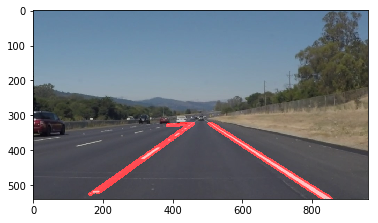

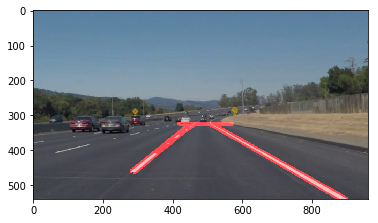

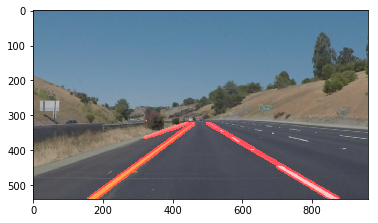

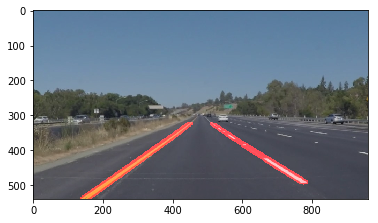

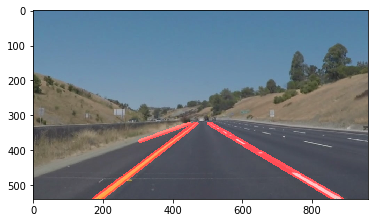

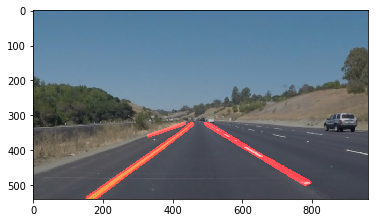

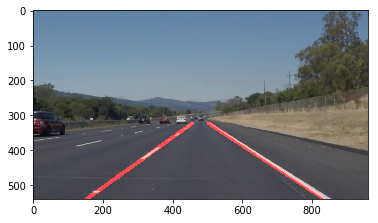

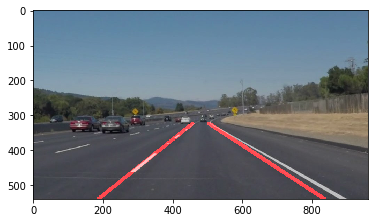

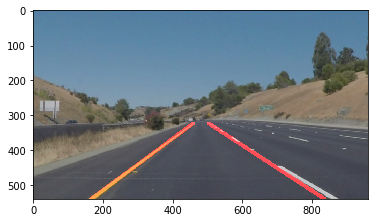

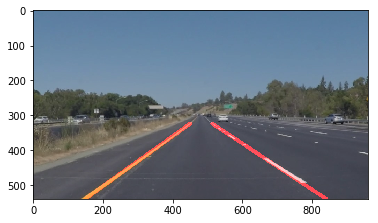

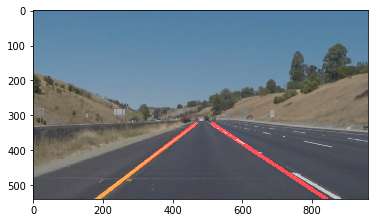

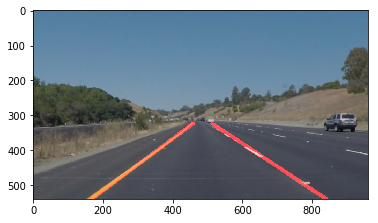

In [5]:
# Gaussian smooth
GAUSSIAN_KERNEL_SIZE = 5

# Canny edge detection
CANNY_LOWER_THRESHOLD = 50
CANNY_UPPER_THRESHOLD = 150

# Hough transform
HOUGH_RHO = 1
HOUGH_THETA = np.pi / 180.0
HOUGH_THRESHOLD = 20
HOUGH_MIN_LENGTH = 20
HOUGH_MAX_LINE_GAP = 300

# region of interest selection
Y_PERCENTILE = 0.6
X_TOP_LEFT_PERCENTILE = 0.4
X_TOP_RIGHT_PERCENTILE = 0.6
X_BOTTOM_LEFT_PERCENTILE = 0.05
X_BOTTOM_RIGHT_PERCENTILE = 0.95

# last left line
last_left = (0, 0, 1, 1)
# last right line
last_right = (0, 0, 1, 1)

def detect_lane_lines(img):
    global last_left
    global last_right
    height, width = img.shape[:2]
    img_gray = convert_to_gray(img)
    img_smooth = smooth(img_gray, GAUSSIAN_KERNEL_SIZE)
    img_edges = detect_edges(img_smooth, 
                             CANNY_LOWER_THRESHOLD, 
                             CANNY_UPPER_THRESHOLD)
    img_interest = select_region_auto(img_edges, Y_PERCENTILE,
                                      X_TOP_LEFT_PERCENTILE, 
                                      X_TOP_RIGHT_PERCENTILE, 
                                      X_BOTTOM_LEFT_PERCENTILE, 
                                      X_BOTTOM_RIGHT_PERCENTILE)
    straight_lines = detect_straight_lines(img_interest, 
                                           HOUGH_RHO, 
                                           HOUGH_THETA, 
                                           HOUGH_THRESHOLD, 
                                           HOUGH_MIN_LENGTH, 
                                           HOUGH_MAX_LINE_GAP)
    img_lanes = draw_straight_lines(straight_lines, height, width)
    return cal_weighted_img(img_lanes, img)

def detect_lane_lines_improved(img):
    global last_left
    global last_right
    height, width = img.shape[:2]
    img_gray = convert_to_gray(img)
    img_smooth = smooth(img_gray, GAUSSIAN_KERNEL_SIZE)
    img_edges = detect_edges(img_smooth, 
                             CANNY_LOWER_THRESHOLD, 
                             CANNY_UPPER_THRESHOLD)
    img_interest = select_region_auto(img_edges, Y_PERCENTILE,
                                      X_TOP_LEFT_PERCENTILE, 
                                      X_TOP_RIGHT_PERCENTILE, 
                                      X_BOTTOM_LEFT_PERCENTILE, 
                                      X_BOTTOM_RIGHT_PERCENTILE)
    straight_lines = detect_straight_lines(img_interest, 
                                           HOUGH_RHO, 
                                           HOUGH_THETA, 
                                           HOUGH_THRESHOLD, 
                                           HOUGH_MIN_LENGTH, 
                                           HOUGH_MAX_LINE_GAP)
    exp_lines = extrapolate_lane_lines(straight_lines, height, Y_PERCENTILE)
    # if no line is found, we use previous line
    if not exp_lines[0]:
        exp_lines[0] = last_left
    else:
        last_left = exp_lines[0]
    if not exp_lines[1]:
        exp_lines[1] = last_right
    else:
        last_right = exp_lines[1]
    img_lanes = draw_straight_lines(exp_lines, height, width)
    return cal_weighted_img(img_lanes, img)

def process_images():
    for fname, img in get_test_images():
        img_final = detect_lane_lines(img)
        plt.figure()
        plt.imshow(img_final)
        plt.savefig(os.path.join('test_image_output', fname))
        
def process_images_improved():
    for fname, img in get_test_images():
        img_final = detect_lane_lines_improved(img)
        plt.figure()
        plt.imshow(img_final)
        plt.savefig(os.path.join('test_image_output', fname[:-4] + '_improved.jpg'))


process_images()
process_images_improved()

## Lane Detection Pipeline for Videos

In [ ]:
def process_videos():
    for fname, video in get_test_videos():
        marked_video = video.fl_image(detect_lane_lines)
        marked_video.write_videofile(os.path.join('test_videos_output', fname), 
                                     audio=False)
        
process_videos()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 15.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:44<00:00, 14.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:33<00:00,  7.42it/s]


In [ ]:
def process_videos_improved():
    for fname, video in get_test_videos():
        marked_video = video.fl_image(detect_lane_lines_improved)
        marked_video.write_videofile(os.path.join('test_videos_output', 
                                                  fname[:-4] + '_improved.mp4'), 
                                     audio=False)
        
process_videos_improved()